This notebook examines data from the Register of Livestock Establishments ([Registro de Establecimientos Pecuarios](https://https://www.sag.gob.cl/ambitos-de-accion/registro-de-establecimientos-pecuarios)) maintained by the Agriculture and Livestock Service of the Chilean Agricultural Ministry. According to the web page, "The RUP corresponds to the mandatory identification of each livestock establishment in the country." The data were obtained (with some difficulty) under Chilean transparency laws by C. Leibsch, a Chilean researcher and animal advocate.

There is one spreadsheet for "pigs" and another for "birds". The spreadsheets don't contain any further information about animal type or life stage, but they do contain farm coordinates and animal numbers, along with some other geographical information (such as the Chilean region each establishment is in).

In [ ]:
#!pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [2]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the data and display a couple of rows, just to show what we have to work with.

In [3]:
df1 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-porcinos-2022 (1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-aves-2022 (2) (3).xlsx')

In [4]:
display(df1.sample(1))
display(df2.sample(1))

,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
26943,DE LA ARAUCANIA,MALLECO,ANGOL,OFICINA ANGOL,09.2.01.0624,QUINTA EL CANELO S/N,KM 2 CAMINO VIEJO A RENAICO ANGOL,MALLECO,703302.0,5816240.0,18.0,0


,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
9836,DEL LIBERTADOR GRAL. BERNARDO O'HIGGINS,COLCHAGUA,SANTA CRUZ,OFICINA SANTA CRUZ,06.3.10.0192,LA VILLA ISLA DE YAQUIL - CRISTIAN BENAVIDES B...,LA VILLA YAQUIL,LA VILLA,278218.0,6168570.0,19.0,50


We now define the animal numbers we are interested in (the 'CANTIDAD' column in the spreadsheets). Setting pig_range = (100, 1e7) and bird_range =(1000, 1e7) produces the scatter plots used in the results document. (Excluding small farms keeps the computations manageable.) It can be useful to temporarily use smaller ranges in order to visually examine farms in a certain size range.

Then we print some information about the data. We can see that:


1.   There are many farms with CANTIDAD=0. It is not clear why this is, or how many farms these animals might actually have.
2.   There are some farms with very large animal numbers (e.g. ~50000 pigs). If we visually inspect those farms on a map, we can see that they are real and are large CAFOs. It is not clear that they are larger than other CAFOs, though.

Overall, it seems that the animal numbers in this dataset are useful but should be used with some caution.

In [5]:
pig_range = (100, 1e7)
bird_range = (1000, 1e7)

In [6]:
def describe_data(df, animal_type, size_range):

  print(f"There are {df.shape[0]} entries in the {animal_type} spreadsheet")

  x = df[(~df['COORDENADA_X'].isnull()) | (~df['COORDENADA_Y'].isnull())]
  print(f"{len(x)} farms have valid coordinates")

  x = df[df['CANTIDAD'] == 0]
  print(f"{len(x)} farms report 0 {animal_type}")

  print(f"The largest farm reports {df['CANTIDAD'].max()} {animal_type}")

  x = df[(df['CANTIDAD'] < size_range[0]) & (df['CANTIDAD'] > 0)]
  print(f"There are {len(x)} farms with 0 < {animal_type} < {size_range[0]}")
  print(f"  - They account for {x['CANTIDAD'].sum()} {animal_type}")

  x = df[(df['CANTIDAD'] > size_range[0]) & (df['CANTIDAD'] < size_range[1])]
  print(f"There are {x.shape[0]} farms with  {size_range[0]} < {animal_type} < {size_range[1]}")
  print(f"  - They account for {x['CANTIDAD'].sum()} {animal_type} \n")

In [7]:
describe_data(df1, 'pigs', pig_range)
describe_data(df2, 'birds', bird_range)

There are 44444 entries in the pigs spreadsheet
40253 farms have valid coordinates
29522 farms report 0 pigs
The largest pigs farm reports 53133 pigs
There are 14706 farms with 0 < pigs < 100
  - They account for 116374 pigs
There are 211 farms with  100 < pigs < 10000000.0
  - They account for 2535881 pigs 

There are 45037 entries in the birds spreadsheet
40831 farms have valid coordinates
3147 farms report 0 birds
The largest birds farm reports 5500000 birds
There are 41243 farms with 0 < birds < 1000
  - They account for 1274458 birds
There are 630 farms with  1000 < birds < 10000000.0
  - They account for 65333716 birds 



The next cell creates histograms of number of animals per farm and cumulative animal numbers. The histograms contain farms of all sizes except those with CANTIDAD=0. Taken at face value (ignoring the reservations mentioned above), these plots indicate that although most farms are small, most animals are on the largest farms.




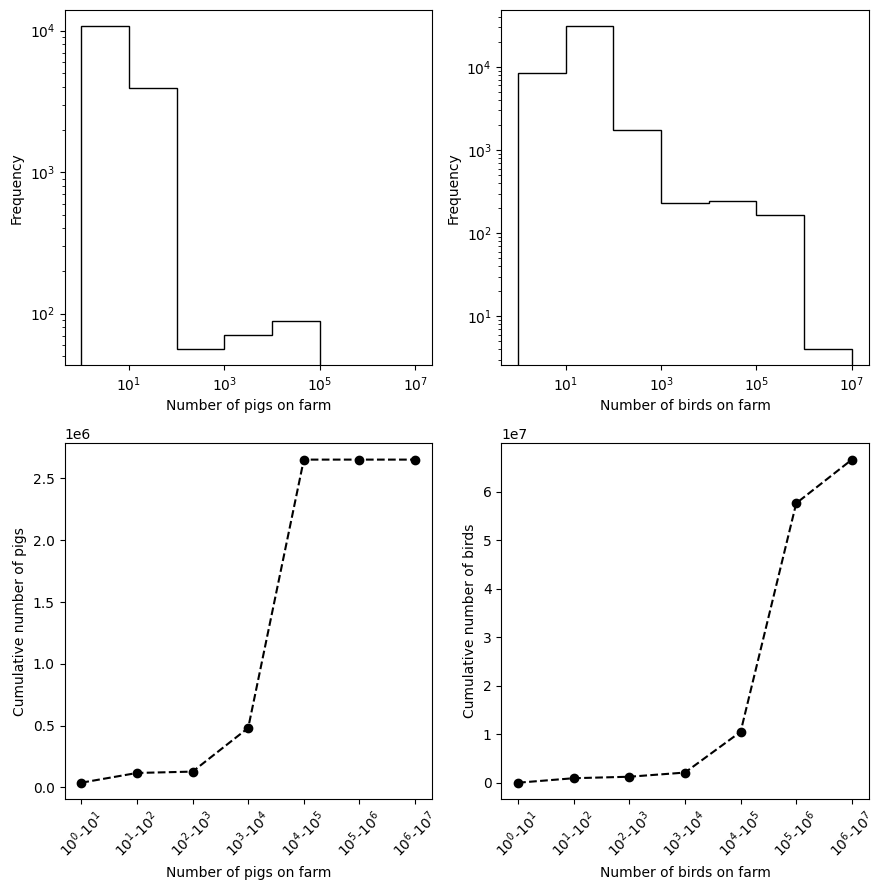

In [8]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

def histo(df, ax_a, ax_b, animal):

  # Histogram
  to_show = df[df['CANTIDAD'] > 0]
  n, bins, _ = ax_a.hist(to_show['CANTIDAD'], bins=[1, 10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7],\
                         log=True, histtype='step', color='k')
  ax_a.set_xscale('log')
  ax_a.set_xlabel(f'Number of {animal} on farm')
  ax_a.set_ylabel('Frequency')

  # Cumulative numbers of animals on small --> large farms
  cumulative = []
  for n, bin in enumerate(bins[:-1]):
    temp = df[(df['CANTIDAD'] >= bin) & (df['CANTIDAD'] < bins[n+1])]
    temp = temp['CANTIDAD'].sum()
    if n == 0:
      cumulative.append(temp)
    else:
      cumulative.append(temp+cumulative[n-1])
  xpos = range(len(cumulative))
  ax_b.plot(xpos, cumulative, marker='o', ms=6, ls='--', color='k')
  ax_b.set_xticks(xpos, [r"10$^0$-10$^1$", "10$^1$-10$^2$", "10$^2$-10$^3$",\
                         "10$^3$-10$^4$", "10$^4$-10$^5$", "10$^5$-10$^6$", "10$^6$-10$^7$"],\
                  rotation=45, ha='center')
  ax_b.set_xlabel(f'Number of {animal} on farm')
  ax_b.set_ylabel(f'Cumulative number of {animal}')

histo(df1, ax1, ax3, 'pigs')
histo(df2, ax2, ax4, 'birds')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_histograms.png')

We will now drop farms with animal numbers outside the ranges of interest defined above, and also convert coordinates and tidy up the data a bit.

In [9]:
# The coords in the original spreadsheets are Eastings and Northings;
# need to convert to Long and Lat

def convertCoords(row):
    crs_from = pyproj.CRS("EPSG:32719")
    crs_to = pyproj.CRS("EPSG:4326")
    lat, lon = pyproj.Transformer.from_crs(crs_from, crs_to).\
                 transform(row['COORDENADA_X'], row['COORDENADA_Y'])
    return pd.Series({'Longitude':lon, 'Latitude':lat})

In [10]:
def refine_data(df, animal_type, size_range):

  columns_to_drop = ['OFICINA', 'RUP', 'RUP_NOMBRE', 'HUSO']
  df = df.drop(columns=columns_to_drop).reset_index(drop=True)

  df = df[(~df['COORDENADA_X'].isnull()) | (~df['COORDENADA_Y'].isnull())]

  df = df[(df['CANTIDAD'] > size_range[0]) & (df['CANTIDAD'] < size_range[1])]

  df[['Longitude', 'Latitude']] = df.apply(convertCoords, axis=1)
  df = df.sort_values(by='Latitude', ascending=False).reset_index(drop=True)

  gdf = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

  gdf = gdf.drop(columns=["Latitude", "Longitude", "COORDENADA_X", "COORDENADA_Y",\
                          "DIRECCION_ESTABLECIMIENTO", "LOCALIDAD"])

  fc = geemap.geopandas_to_ee(gdf[["geometry"]])

  return gdf, fc

In [11]:
pigs, pigs_fc = refine_data(df1, 'pigs', pig_range)
birds, birds_fc = refine_data(df2, 'birds', bird_range)

It would now be interesting to examine the characteristics of buildings associated with the pig and bird farms in the size range of interest. We can do that by associating buildings in the global building footprint database with the Chilean farm coordinates. It's not feasible to do that for all of Chile, though. Instead, we will identify the 'comunas' that contain most of the farms, and restrict the building database to only those areas. (Chile is divided into regions that are subdivided into provincias and then comunas.)

The top 25 comunas account for 157/206 pig farms (76%)
The top 35 comunas account for 468/626 bird farms (75%)


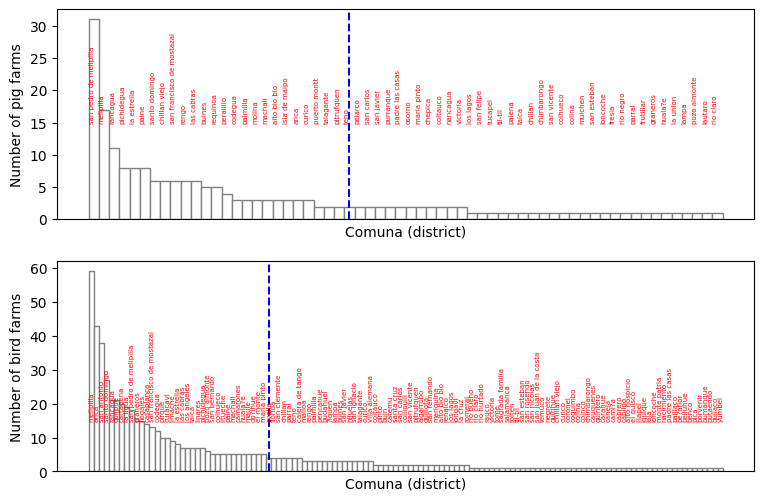

In [12]:

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

def bars(df, ax, animal, num):

  df = df.groupby(['COMUNA']).size().sort_values(ascending=False).reset_index(name="Num")
  labelpos = ax.bar(x=df['COMUNA'], height=df['Num'], color='w', edgecolor='0.5',
                    width=1)
  for n, comuna in enumerate(df['COMUNA']):
    ax.text(labelpos[n].xy[0], 15, comuna.lower(), ha='left', rotation=90,\
            color='r', size=5)
  ax.axvline(num, color='blue', ls='--')
  ax.set_xticks([])
  ax.set_xlabel('Comuna (district)')
  ax.set_ylabel(f'Number of {animal} farms')

  total = df['Num'].sum()
  in_top_n = df['Num'].head(num).sum()
  percent = in_top_n / total * 100
  print(f'The top {num} comunas account for {in_top_n}/{total} {animal} farms ({percent:.0f}%)')

  return df['COMUNA'].head(num).to_list()

pigs_is_at = bars(pigs, ax1, 'pig', 25)
birds_is_at = bars(birds, ax2, 'bird', 35)

Get the ancillary data - shapefiles of the Chilean regions, and building footprint data - then identify the buildings that are associated with farms. Then, make a map that shows those buildings, and also save the buildings to a geojson file for future use. Some of these steps take quite a long time to run, so the time-consuming ones are commented out in the next 3 cells. Uncomment the relevant lines to see the buildings on the map and/or recreate the saved files.

In [13]:
comunas = gpd.read_file(\
            '/content/drive/MyDrive/CAFO_data/Chile/shapefiles/chl_admbnda_adm3_bcn_20211008.shp'\
                          )
comunas.crs="EPSG:4326"
comunas = comunas[['ADM3_ES', 'ADM2_ES', 'geometry']]
comunas['ADM3_ES'] = comunas['ADM3_ES'].apply(unidecode)

In [14]:
min_building_size = 100

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/CHL")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
)

# Some Comunas in the pig and bird records don't match those in the shapefile
# of administrative regions. This dict is used to "correct" those entries.
# Pozo Almonte seems to be real and missing from the admin region shapefile, so
# we will just have to always skip that one
needs_standardizing = {"Alto Bio Bio": "Alto Biobio",\
                       "Isla De Maipo": "Isla de Maipo",\
                       "San Pedro De Melipilla": "San Pedro",\
                       "San Francisco De Mostazal": "Mostazal",\
                       "Do?Ihue": "Donihue",\
                       "Huala?E": "Hualane"}

where = []
for comuna in [unidecode(s.title()) for s in set(pigs_is_at + birds_is_at)]:
  try:
    where.append(needs_standardizing[comuna])
  except KeyError:
    where.append(comuna)

building_dict = {}
geometries_dict = {}
for comuna in where:

  comuna_geom = comunas[comunas['ADM3_ES'] == comuna]

  # identify and skip any remaining Comunas with nonstandardized names
  if len(comuna_geom) == 0:
    print(f"No entry found in Comunas list for {comuna}; skipping")
    continue

  comuna_geom = geemap.geopandas_to_ee(comuna_geom[['geometry']])
  geometries_dict[comuna] = comuna_geom
  building_dict[comuna] = buildings.filterBounds(comuna_geom)


No entry found in Comunas list for Pozo Almonte; skipping


In [ ]:

Map = geemap.Map()
Map.centerObject(pigs_fc.first().geometry(), 10)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

region_viz = {'color':'red', 'fillColor':'00000000'}
building_viz = {'color':'orange', 'fillColor':'00000000'}

Map.add_basemap("HYBRID")
for comuna in building_dict:
#  Map.addLayer(building_dict[comuna], building_viz, "")
  Map.addLayer(geometries_dict[comuna].style(**region_viz), {}, "")
Map.addLayer(pigs_fc, {'color':'pink', 'width':6}, "Pig farms")
Map.addLayer(birds_fc, {'color':'cyan', 'width':6}, "Bird farms")


Map

In [ ]:
def write_to_file(fc, filename):

  task = ee.batch.Export.table.toDrive(
        collection=fc,
        description=filename,
        folder='Chile',
        fileFormat='GeoJSON',
    )

  task.start()

#for comuna, buildings in building_dict.items():
#  write_to_file(buildings, f"{comuna}_{min_building_size}m2")

In [ ]:
# Uncomment this line to see the progress of the 5 most recent file-writing tasks

#utils.ee_task_status()

Here we read in the saved building data and use it to make plots. We do a spatial join to find the buildings that are within 200 m of each farm in the size range of interest. Then, we find the minimum rotated rectangle for each building ("the general minimum bounding rectangle that contains the object"), and calculate its length and aspect ratio. As most buildings are rectangular anyway, using the minimum rotated rectangle shouldn't affect the accuracy of the results much.

Finally, we plot the number, median individual area, median length, and median aspect ratio of the buildings within 200 m of each set of farm coordinates vs number of animals reported per farm.

In [15]:
# Read the saved building file for each comuna

files = glob('/content/drive/MyDrive/CAFO_data/Chile/*m2.geojson')
gdf_list = []
for file in files:
  gdf_list.append(gpd.read_file(file))
gdf = pd.concat(gdf_list)
print(f"There are {len(gdf)} buildings >{min_building_size} sq m in the selected comunas")

There are 705541 buildings >100 sq m in the selected comunas


In [16]:
gdf = gdf[['area_in_meters', 'geometry']]
gdf['buildings_geom'] = gdf['geometry'] # to preserve building geometry after join

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [17]:
# Buffer the farm gdf geometry and do a spatial join with the buildings gdf
# to identify buildings within <dist> m

dist = 200
def join_farms_and_buildings(farms, regions, dist):

  for_join = farms[farms['COMUNA'].isin(regions)]
  for_join = for_join.to_crs("EPSG:32719")
  for_join['geometry'] = for_join['geometry'].buffer(dist)
  for_join = for_join.to_crs("EPSG:4326")

  #inner join excludes farms w/o buildings' is that what I want?
  joined = for_join.sjoin(gdf, how='inner', predicate='intersects')
  joined['index_right'] = joined['index_right'].astype(int)

  return joined

pig_buildings = join_farms_and_buildings(pigs, pigs_is_at, dist)
bird_buildings = join_farms_and_buildings(birds, birds_is_at, dist)

In [18]:
# Calculate the length and aspect ratio of each building
# (actually, of its minimum rotated rectangle)

def get_dimensions(gdf):

  def calc_length_etc(row):

    x, y = row.exterior.coords.xy
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])),\
                Point(x[1], y[1]).distance(Point(x[2], y[2])))
    length = max(edge_length)
    width = min(edge_length)
    aspect_ratio = length / width
    return pd.Series({'Length':length, 'Aspect Ratio':aspect_ratio})

  temp = gdf['buildings_geom'].minimum_rotated_rectangle()
  temp = temp.to_crs("EPSG:32719")
  dimensions = temp.apply(calc_length_etc).reset_index(drop=False)
  new = gdf.copy().reset_index(drop=False).drop(columns=["index_right"])
  new[['Length', 'Aspect Ratio']] = dimensions[['Length', 'Aspect Ratio']]

  return new

pig_buildings_2 = get_dimensions(pig_buildings)
bird_buildings_2 = get_dimensions(bird_buildings)

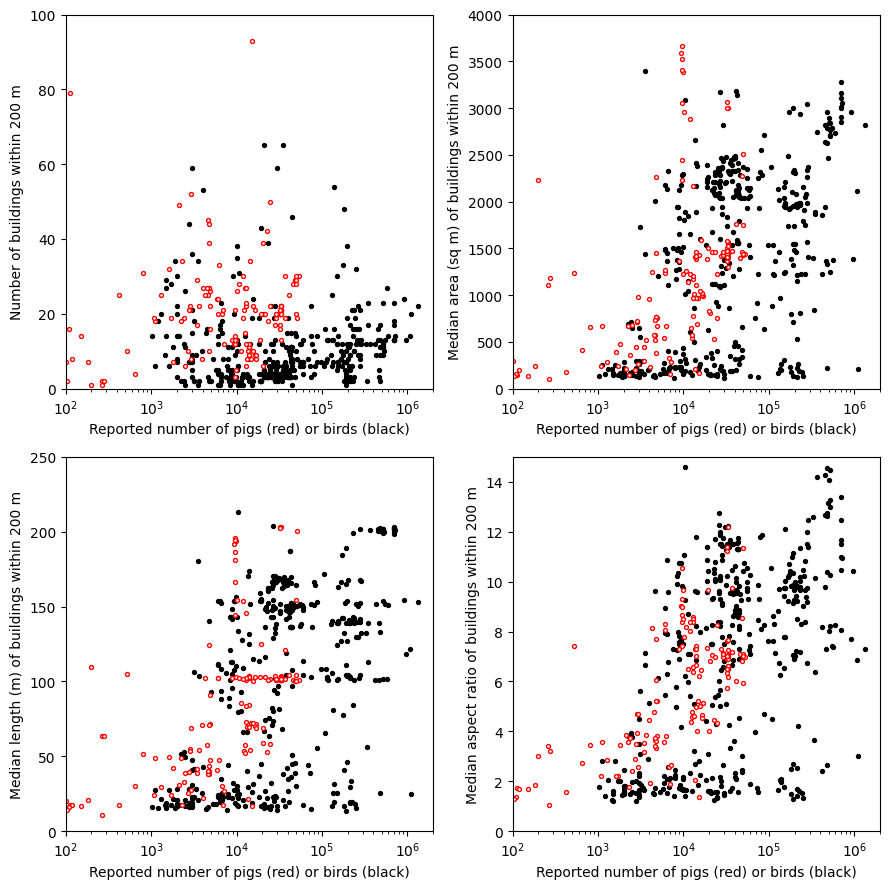

In [19]:
# Make the scatter plots

def building_scatterplots(pig_dfs, bird_dfs, dist):

  def axis_stuff(ax):
    ax.set_xlim(1e2, 2e6)
    ax.set_xscale('log')
    ax.set_xlabel(f'Reported number of pigs (red) or birds (black)')

  # Numbers of buildings vs quantity of animals
  for n, df in enumerate([pig_dfs[0], bird_dfs[0]]):
    groups = df.groupby(level=0)
    for group in groups:
      n_animals = group[1]['CANTIDAD'].unique()[0]
      n_buildings = len(group[1])
      if n == 0:
        ax1.scatter(n_animals, n_buildings, marker='o', s=8, facecolor='w',\
                    edgecolor='r', zorder=2)
      else:
        ax1.scatter(n_animals, n_buildings, marker='o', s=8, color='k')
  axis_stuff(ax1)
  ax1.set_ylim(0, 100)
  ax1.set_ylabel(f'Number of buildings within {dist} m')

  # Median building sizes vs quantity of animals
  for n, df in enumerate([pig_dfs[0], bird_dfs[0]]):
    groups = df.groupby(level=0)
    for group in groups:
      n_animals = group[1]['CANTIDAD'].unique()[0]
      med_area = group[1]['area_in_meters'].median()
      if n == 0:
        ax2.scatter(n_animals, med_area, marker='o', s=8, facecolor='w',\
                    edgecolor='r', zorder=2)
      else:
        ax2.scatter(n_animals, med_area, marker='o', s=8, color='k')
  axis_stuff(ax2)
  ax2.set_ylim(0, 4000)
  ax2.set_ylabel(f'Median area (sq m) of buildings within {dist} m')

  # Building lengths vs quantity of animals
  for n, df in enumerate([pig_dfs[1], bird_dfs[1]]):
    groups = df.groupby('index')
    for group in groups:
      n_animals = group[1]['CANTIDAD'].unique()[0]
      med_length = group[1]['Length'].median()
      if n == 0:
        ax3.scatter(n_animals, med_length, marker='o', s=8, facecolor='w',\
                    edgecolor='r', zorder=2)
      else:
        ax3.scatter(n_animals, med_length, marker='o', s=8, color='k')
  axis_stuff(ax3)
  ax3.set_ylim(0, 250)
  ax3.set_ylabel(f'Median length (m) of buildings within {dist} m')

  # Building aspect ratios vs quantity of animals
  for n, df in enumerate([pig_dfs[1], bird_dfs[1]]):
    groups = df.groupby('index')
    for group in groups:
      n_animals = group[1]['CANTIDAD'].unique()[0]
      med_aspect = group[1]['Aspect Ratio'].median()
      if n == 0:
        ax4.scatter(n_animals, med_aspect, marker='o', s=8, facecolor='w',\
                    edgecolor='r', zorder=2)
      else:
        ax4.scatter(n_animals, med_aspect, marker='o', s=8, color='k')
        ax4.ax
  axis_stuff(ax4)
  ax4.set_ylim(0, 15)
  ax4.set_ylabel(f'Median aspect ratio of buildings within {dist} m')

  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_farm_buildings.png')


_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))
building_scatterplots([pig_buildings, pig_buildings_2],\
                      [bird_buildings, bird_buildings_2], dist)